# Quantum Kernel Estimation and Variational Classifiers applied to binary classification
## Advanced Quantum Mechanics - Quantum machine learining Workshop

### Contents of this notebook:

- [Handwritten digits dataset exploration](#MNIST_de)
- [Handwritten digits classification](#MNIST_general)
    - [Classical SVM](#MNIST_CL)
    - [Quantum Kernel Estimation SVM](#MINIST_QKE)
    - [Variational Quantum Classifier](#MNIST_VQC)
    - [Performance metrics](#MNIST_me)
- [Ad hoc dataset exploration](#AH_de)
- [Ad hoc dataset classification](#AH_general)
    - [Classical SVM](#AH_CL)
    - [Quantum Kernel Estimation SVM](AH_QKE)
    - [Variational Quantum Classifier](AH_VQC)
    - [Performance metrics](#AH_me)
    
Authors:

Ario Altamura\
Giulio Crognaletti\
Antonio Mastropasqua

## Handwritten digits dataset exploration <a class="anchor" id="MNIST_de"></a>

In [29]:
#general imports
import matplotlib.pyplot as plt
import numpy as np

from typing import Union, List, Tuple, Any

Dataset has to be imported from scikit-learn library

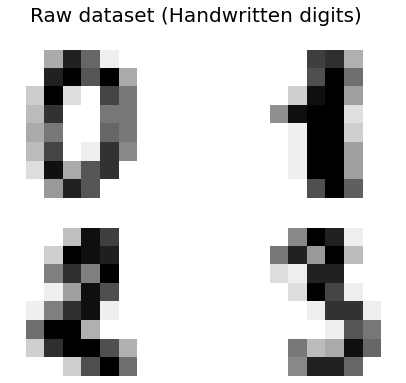

In [30]:
from sklearn.datasets import load_digits

#dataset retrival
n_class = 10
data_all,label_all = load_digits(n_class=n_class,return_X_y = True)

#plot few samples
rows = 2
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(8,6))

for i in range(rows):
    for j in range(cols):
        axs[i][j].set_axis_off()
        axs[i][j].imshow(data_all[i*cols+j].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')


plt.suptitle("Raw dataset (Handwritten digits)", fontsize=20)
plt.show()

This notebook focuses on binary classification, hence we must choose the relevant labels. The most similar digits appear to be "3" and "8" in this case

In [31]:
def select_only(data:np.ndarray, label:np.ndarray, accepted:List)->Tuple[np.ndarray,np.array]:
    """Selects only datapoints with lable in accepted list"""

    #list data structures are faster when changing the dimension of the object
    data = data.tolist()
    label = label.tolist()

    i = 0
    while i < len(label): 
        if any([label[i] == d for d in accepted]):
            i+=1
        else:
            data.pop(i)
            label.pop(i)

    #restor the starting type
    data = np.asarray(data)
    label = np.asarray(label)
    
    return data,label

#select the most similar digits
accepted = [3,8]
data_full, label_full = select_only(data_all, label_all, accepted)

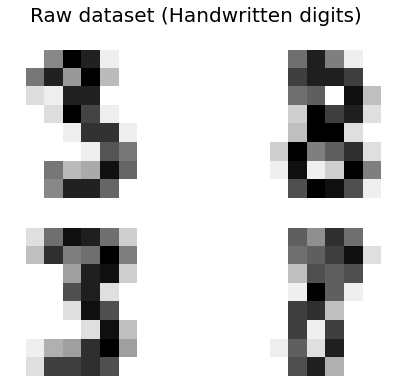

In [32]:
#plot few samples
rows = 2
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(8,6))

for i in range(rows):
    for j in range(cols):
        axs[i][j].set_axis_off()
        axs[i][j].imshow(data_full[i*cols+j].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')


plt.suptitle("Raw dataset (Handwritten digits)", fontsize=20)
plt.show()

Dimensionality Reduction - PCA

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

n_dim = 4

#Dimensionality reduction
pca = PCA(n_components=n_dim).fit(data_full)

print(f"Explained Variance: {100*sum(pca.explained_variance_ratio_)} % \n\nDetail:")
for i,pc in enumerate(pca.explained_variance_ratio_): print(f"Pincipal component {i+1}:\t{pc*100} %")

data_full = pca.transform(data_full)

# Normalise
std_scale = StandardScaler().fit(data_full)
data_full = std_scale.transform(data_full)

# Scale
minmax_scale = MinMaxScaler((-1, 1)).fit(data_full)
data_full = minmax_scale.transform(data_full)

#randomly permute the dataset
p = np.random.permutation(len(data_full))
data_full = data_full[p]
label_full = label_full[p]

Explained Variance: 52.213628996567486 % 

Detail:
Pincipal component 1:	24.81271509912808 %
Pincipal component 2:	11.415463340382528 %
Pincipal component 3:	9.880911452548565 %
Pincipal component 4:	6.1045391045083175 %


Test sets and training sets must be split. To ensure a reasonable usage of computational resources on IBMQ real quantum processors, training and test sets must be limited. Tradeoff:

- 50 points for training
- 50 points for testing on real hardware
- 300 points for a larger test (to be run on simulators)

In [34]:
train_size = 50
test_size_hw = 50
test_size_sim = 300

total_points = train_size + max(test_size_hw,test_size_sim)
if total_points > len(data_full):
    raise ValueError(f"Incompatible train/test size. Total points: {len(data_full)}, asked: {total_points}")

#choose training and test sets
data = data_full[:train_size]
label = label_full[:train_size]

data_test_hw = data_full[train_size:train_size+test_size_hw]
label_test_hw = label_full[train_size:train_size+test_size_hw]

data_test_sim = data_full[train_size:train_size+test_size_sim]
label_test_sim = label_full[train_size:train_size+test_size_sim]

print(f"Train size: {train_size}\nTest size (Real Hardware): {test_size_hw}\nTest size (Noisy simulator): {test_size_sim}")

Train size: 50
Test size (Real Hardware): 50
Test size (Noisy simulator): 300


Plot the training set for visualization

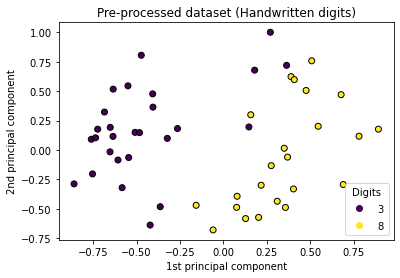

In [35]:
plt.title("Pre-processed dataset (Handwritten digits)")
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
scatter = plt.scatter(data[:,0],data[:,1],c=label,edgecolors="k")
plt.legend(*scatter.legend_elements(),loc="lower right", title="Digits")
plt.show()

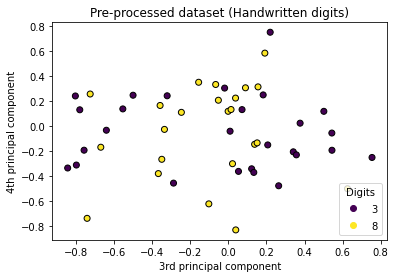

In [36]:
if n_dim >= 4:
    plt.title("Pre-processed dataset (Handwritten digits)")
    plt.xlabel("3rd principal component")
    plt.ylabel("4th principal component")
    scatter = plt.scatter(data[:,2],data[:,3],c=label,edgecolors="k")
    plt.legend(*scatter.legend_elements(),loc="lower right", title="Digits")
    plt.show()

In [37]:
#choose only the first 2 dimensions -> they are enough for this problem instance
feature_dim = 2

data = data[:,0:feature_dim]
data_test_hw = data_test_hw[:,0:feature_dim]
data_test_sim = data_test_sim[:,0:feature_dim]

## Handwritten digits classification <a class="anchor" id="MNIST_general"></a>

Handy functions for later use

In [156]:
from sklearn.svm._classes import SVC as SVC_type
from qiskit_machine_learning.algorithms import VQC as VQC_type

Classifier_type = Union[SVC_type,VQC_type]

def print_support(trained_classifier:SVC_type)->None:
    """Print basic information about support vectors of the SVC classifier"""
    
    print(f"Number of support vectors per class:")
    for c,n in zip(trained_classifier.classes_,trained_classifier.n_support_):
        print(f"Class {c}: {n}")
        
def make_meshgrid(x:np.ndarray, y:np.ndarray,N:int =100) -> Tuple[np.ndarray,np.ndarray]:
    """Create a mesh of points to plot in"""
    
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    
    edge = 0.05
    dx, dy = (x_max-x_min)*edge, (y_max-y_min)*edge
    
    x, y = np.meshgrid(np.linspace(x_min-dx, x_max+dx,N), np.linspace(y_min-dy, y_max+dy,N))
    return x, y


def plot_contour(X:np.ndarray,y:np.ndarray,trained_classifier:Classifier_type,title="",wrapper = None,**params) -> None:
    """Plot the decision boundaries for a classifier"""
    
    if isinstance(trained_classifier,VQC_type):
        if wrapper is None: 
            raise ValueError("Using VQC classifier, value_map wrapper cannot be None")
    
    x_mesh, y_mesh = make_meshgrid(X[:,0],X[:,1])
    
    if wrapper is None:
        wrapper = lambda x: x
        
    Z = wrapper(trained_classifier.predict(np.c_[x_mesh.flatten(), y_mesh.flatten()]))
    Z = Z.reshape(x_mesh.shape)
    
    plt.title(title)
    plt.contourf(x_mesh, y_mesh, Z,**params)
    plt.scatter(X[:,0],X[:,1],c=y,edgecolors="k")
    plt.show()

### Classical SVM <a class="anchor" id="MNIST_CL"></a>

Train the classifier

In [40]:
from sklearn.svm import SVC

#choose kernel type/define a new kernel
kernel_type = "rbf"

#build the classifier
classifier = SVC(kernel=kernel_type,decision_function_shape='ovr',probability = True)
classifier.fit(data,label)

print_support(classifier)

Number of support vectors per class:
Class 3: 10
Class 8: 11


If the dimension allows it, make a contour plot to represent classifier

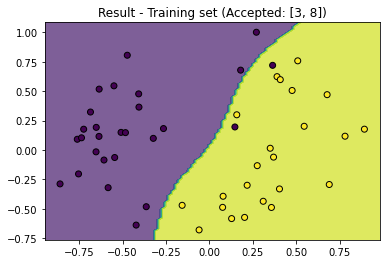

In [41]:
if feature_dim == 2:
    _ = plot_contour(data,label,classifier,title=f"Result - Training set (Accepted: {accepted})",alpha=0.7)

Get the scores both the training sets

Accuracy - Test set real hardware: 0.98
Accuracy - Test set simulator: 0.9666666666666667


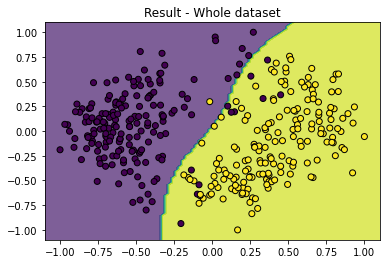

In [42]:
from sklearn.metrics import accuracy_score

#classical score calculation - HW
c_score_hw = accuracy_score(label_test_hw,classifier.predict(data_test_hw))

#classical score calculation - Simulator
c_score_sim = accuracy_score(label_test_sim,classifier.predict(data_test_sim))


print(f"Accuracy - Test set real hardware: {c_score_hw}\nAccuracy - Test set simulator: {c_score_sim}")

if feature_dim == 2:
    _ = plot_contour(data_full,label_full,classifier,title="Result - Whole dataset",alpha=0.7)

### Quantum Kernel Estimation SVM <a class="anchor" id="MNIST_QKE"></a>

Establish what IBMQ processor to use. In principle we could use up to 4 features, so we need at least 4 qubits.

In [43]:
from qiskit.providers.ibmq import least_busy
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview

#token for each of the group components
TOKEN_giulio = "04c1b1dfad0e6ee10e9031fbcb22f6f46eee54faa9cc6748f9d6c6b0c2b30b0c82188e2aa65d7c7dea37c0ee9dbaf31ffbda433a1601fa9054baa3b447f71580"
TOKEN_ario = None
TOKEN_antonio = None

#get suitable avilable backends
provider = IBMQ.enable_account(TOKEN_giulio)
large_enough_devices = provider.backends(filters=lambda x: x.configuration().n_qubits > 4 and not x.configuration().simulator)
backend_overview()

ibmq_manila                  ibmq_quito                   ibmq_belem
-----------                  ----------                   ----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 306            Pending Jobs: 272            Pending Jobs: 9
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      167.0          Avg. T1:      86.0           Avg. T1:      100.8
Avg. T2:      57.3           Avg. T2:      89.3           Avg. T2:      118.4



ibmq_lima                   ibmq_bogota                  ibmq_armonk
---------                   -----------                  -----------
Num. Qubits:  5             Num. Qubits:  5              Num. Qubits:  1
Pending Jobs: 1             Pending Jobs: 26             Pending Jobs: 178
Least busy:   True          Least busy:   False          Least busy:   False
Operational:  True          Operation

Quanrum instances definition

In [44]:
from qiskit.providers.ibmq import least_busy
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit import BasicAer
from qiskit.providers.aer import AerSimulator
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 12345
algorithm_globals.random_seed = seed

#simulator => Analytical simulation of the circuit, no noise, no statistical error from measurement readout fluctuations
sv_backend = BasicAer.get_backend('statevector_simulator')
sv_simulator = QuantumInstance(sv_backend, seed_simulator=seed, seed_transpiler=seed)

#choose the real quantum processor to use in the future
#real_hw = least_busy(provider.backends())
real_hw = provider.backends("ibmq_lima")[0]
ibmq_lima = QuantumInstance(real_hw, seed_simulator=seed, seed_transpiler=seed)

#setup the noise-model simulator (with 4000 shots, which is the default on IBMQ_lima)
noisy_backend = AerSimulator.from_backend(real_hw)
fake_lima = QuantumInstance(noisy_backend,shots = 4000,seed_simulator=seed, seed_transpiler=seed)

backends = [sv_backend, real_hw, noisy_backend]
quantum_instances = [sv_simulator, ibmq_lima, fake_lima]

print(f"Using backends:\n\nStatevector: {sv_backend}\nReal HW: {real_hw}\nNoisy simulator:\n{fake_lima}")

Using backends:

Statevector: statevector_simulator
Real HW: ibmq_lima
Noisy simulator:

Qiskit Terra version: 0.19.1
Backend: 'aer_simulator(ibmq_lima) (None)', with following setting:
{'basis_gates': ['cx', 'id', 'rz', 'sx', 'x', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop'], 'coupling_map': [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]}
{'initial_layout': None, 'seed_transpiler': 12345, 'optimization_level': None}
RunConfig(max_credits=10, seed_simulator=12345, shots=4000)
{'timeout': None}
{}
{}
Measurement mitigation: No

Feature map definition

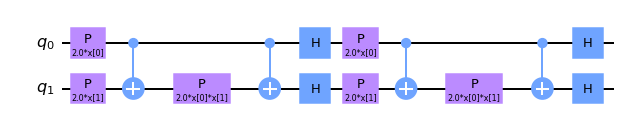

In [45]:
#Data Mapping function
from functools import reduce
from qiskit.circuit.library import PauliFeatureMap
from qiskit.compiler import transpile

def DMF(x:np.ndarray)->float:
    """Custom Data Mapping Funcion"""
    
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: m * n, x)
    return coeff

#Feature map definition
quantum_feature_map = PauliFeatureMap(paulis=['X','XX'],feature_dimension=feature_dim, reps=2, entanglement="linear",data_map_func=DMF)

#draw
transpile(quantum_feature_map, basis_gates = ["h","p","cx"],optimization_level=2).draw("mpl")

Put the Quantum kernels together and build the Support Vector Classifier
Quantum Kernels:

- $\texttt{quantum_kernel_sv} \rightarrow$ Statevector simulation
- $\texttt{quantum_kernel_hw} \rightarrow$ Real Hardware
- $\texttt{quantum_kernel_sim} \rightarrow$Simulated Hardware

In [46]:
from qiskit_machine_learning.kernels import QuantumKernel

#Quantum Kernels definition
quantum_kernel_sv  = QuantumKernel(feature_map=quantum_feature_map, quantum_instance=sv_simulator)
quantum_kernel_hw  = QuantumKernel(feature_map=quantum_feature_map, quantum_instance=ibmq_lima)
quantum_kernel_sim = QuantumKernel(feature_map=quantum_feature_map, quantum_instance=fake_lima)

#definiton of the model
q_svc = SVC(kernel=quantum_kernel_hw.evaluate,decision_function_shape='ovr',probability = True)

#training has been done on real hardware
q_svc.fit(data, label)

print_support(q_svc)

Number of support vectors per class:
Class 3: 10
Class 8: 9


In [89]:
qke_preds_hw = q_svc.predict(data_test_hw)
qke_score_hw = accuracy_score(label_test_hw,qke_preds_hw)
print(f'Quantum kernel classification test score on HW: {qke_score_hw}')

Quantum kernel classification test score on HW: 0.98


In [90]:
#change the kernel used for larger test - now we use noisy simulator
q_svc.set_params(**{"kernel":quantum_kernel_sim.evaluate})

qke_preds_sim = q_svc.predict(data_test_sim)
qke_score_sim = accuracy_score(label_test_sim,qke_preds_sim)
print(f'Quantum kernel classification test score on simulated HW: {qke_score_sim}')

Quantum kernel classification test score on simulated HW: 0.9633333333333334


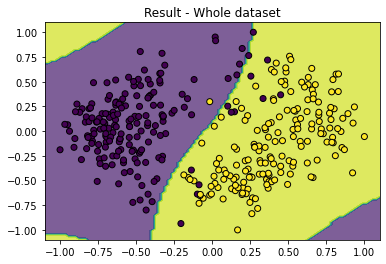

In [49]:
if feature_dim == 2:
    
    #change the kernel used for contour plotting - now we use statevector simulator
    q_svc.set_params(**{"kernel":quantum_kernel_sv.evaluate})
    
    _ = plot_contour(data_full,label_full,q_svc,title=f"Result - Whole dataset",alpha=0.7)

### Variational Quantum Classifier <a class="anchor" id="MNIST_VQC"></a>

We use the VQC class provided by qiskit. It requires one-hot vectors as labels.

In [50]:
#One-hottify the datset

def one_hottify(labels:np.ndarray,values:List)->np.ndarray:
    """Converts a categorical variable with values in values, to a one-hot vector variable"""
    return np.asarray([[int(v==l) for v in values] for l in labels])

#we use the accepted list defined above to one-hottify the labels
label_1h = one_hottify(label,accepted)
label_test_1h_hw = one_hottify(label_test_hw,accepted)
label_test_1h_sim = one_hottify(label_test_sim,accepted)

All components of VQC must be defined and initialized

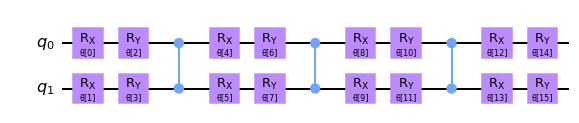

In [68]:
from qiskit_machine_learning.algorithms import VQC
from qiskit_machine_learning.utils.loss_functions import CrossEntropySigmoidLoss, L1Loss, L2Loss, CrossEntropyLoss
from qiskit.algorithms.optimizers import SPSA, COBYLA, SLSQP, AQGD, QNSPSA
from qiskit.circuit.library import TwoLocal, PauliFeatureMap

#Define VQC

#shape parameters
n_input_data = len(data[0])
n_qubits = n_input_data
L = 3
L_feature = 2

def VQA_DMF(x:np.ndarray) -> float:
    """Custom Data Mapping Funcion"""
    
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: m * n, x)
    return coeff

ansatz = TwoLocal(n_qubits,["rx","ry"],"cz","linear",reps = L)
feature_map = PauliFeatureMap(paulis=['X','XX'],feature_dimension = n_input_data,reps = L_feature,entanglement="linear",data_map_func=VQA_DMF)
loss = CrossEntropyLoss()
optimizer = SPSA(maxiter = 100)

#Callback parameters
C = 0
intermediate_loss = []
weight_parameters = []
skip = 10
    
def callback (w:np.ndarray,loss:float)->None:
    
    global C
    global intermediate_loss
    global weight_parameters

    #at each iteration append the current loss and total number of iterations (both simulated and real hardware)
    intermediate_loss.append((C,loss))
    
    #avoid congestion in the output
    if C%skip == 0: 
        print(f"[{C}] Loss: {loss}")
        
    C+=1
    
    #the final parameters will be saved in this global parmeters
    weight_parameters = w

#initially, we use noisy simulator to reach a warm start for the optimization on the real hardware
vqc = VQC(n_qubits, feature_map, ansatz, loss, optimizer, quantum_instance = fake_lima, warm_start=True, callback=callback)
vqc.ansatz.decompose().draw()

In [69]:
#fit the model to the training data
vqc.fit(data,label_1h)

[0] Loss: 56.01659261156818
[10] Loss: 65.38905636101
[20] Loss: 61.765445844085534
[30] Loss: 62.628994165733474
[40] Loss: 57.055621548585414
[50] Loss: 59.36783623589128
[60] Loss: 38.523382175398694
[70] Loss: 31.075549595990566
[80] Loss: 28.906869315581524
[90] Loss: 24.900484679001565
[100] Loss: 22.287838733142664
[110] Loss: 25.74868648954114
[120] Loss: 20.970610367487023
[130] Loss: 20.351474511300417
[140] Loss: 20.93909812777768
[150] Loss: 21.634286137660176
[160] Loss: 20.897442940878253
[170] Loss: 21.665113635627346
[180] Loss: 20.028058226825134
[190] Loss: 21.908726698154325
[200] Loss: 20.37895681380343
[210] Loss: 19.877814625022907
[220] Loss: 19.114422771678623
[230] Loss: 20.931360142904392
[240] Loss: 21.604145050986084
[250] Loss: 18.74508307043862


Warm start is implemented by building a new classifier, and using previous results as initial parameters 

In [70]:
#warm start - real HW

#saves current number of optimization steps
first_iter = C

#limit the number of iterations on real HW
optimizer = SPSA(maxiter = 20)

#build a new classifier with "initial_point = weight_parameters"
vqc = VQC(n_qubits, feature_map, ansatz, loss, optimizer, quantum_instance = ibmq_lima , initial_point = weight_parameters, callback=callback)

#repeat the fitting, now with real HW
vqc.fit(data,label_1h)

[260] Loss: 27.358875598929906
[270] Loss: 19.764825009858342


In [71]:
#compute predictions - HW datatset
qpreds_hw = vqc.predict(data_test_hw)

In [76]:
def indexify(labels:np.ndarray,values:List)->np.ndarray:
    """Associates to one-hot vectors the labels"""
    
    def which(l):
        for i,v in enumerate(l):
            if v != 0: break
        return values[i]
    
    return np.asarray([which(l) for l in labels])

#compute score
qpreds_i_hw = indexify(qpreds_hw,accepted)
vqc_score_hw = accuracy_score(label_test_hw,qpreds_i_hw)

print(f'Variational classifier test score on HW: {vqc_score_hw}')

Variational classifier test score on HW: 0.98


In [73]:
#compute predictions - simulator datatset

#change the classifier's quantum instance using CircuitQNN's interface
vqc.neural_network.quantum_instance = fake_lima
qpreds_sim = vqc.predict(data_test_sim)

In [78]:
#compute score
qpreds_i_sim = indexify(qpreds_sim,accepted)
vqc_score_sim = accuracy_score(label_test_sim,qpreds_i_sim)

print(f'Variational classifier test score on simulated HW: {vqc_score_sim}')

Variational classifier test score on simulated HW: 0.9666666666666667


Plots of classifier's shape and optimization profile

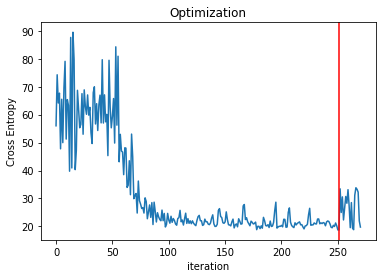

In [79]:
X = []
Y = []

for x,y in intermediate_loss:
    X.append(x)
    Y.append(y)
    
plt.title("Optimization")
plt.xlabel("iteration")
plt.ylabel("Cross Entropy")
plt.plot(X,Y)
plt.axvline(x=first_iter, color="r")
plt.show()

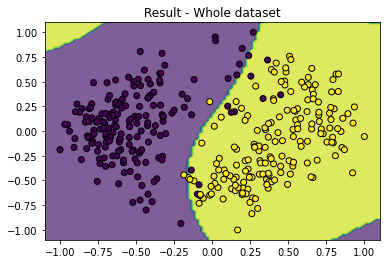

In [80]:
if feature_dim == 2: 
    #change the backend used for contour plotting - now we use statevector simulator
    vqc.neural_network.quantum_instance = sv_simulator
    
    _ = plot_contour(data_full,label_full,vqc,wrapper = lambda x : indexify(x,accepted),title=f"Result - Whole dataset",alpha=0.7)

Previous result use Qiskit VQC class. Here classification is done estimating the probability of each point $\vec{x_i}$ to be in a certain class, i.e. to be a certan $c \in C = \{3,8\}$
This is achived by using a decision function $f:\{0,1\}^n \rightarrow C$, which by default is built like this: 

- the parity operator $Z\otimes Z$ which acts like $\{0,1\}^n \rightarrow \{-1,1\}$
- a correspondence rule, e.g. $1 \rightarrow 8$ and $-1 \rightarrow 3$

Then, if we denote by $U(\vec{x},\vec{\theta})$ the classifier's circuit, the following expectation value is be used to estimate the probabilities:

$$p_3(\vec{x_i}) = \frac{1}{2}\left(1-\langle 0 | U(\vec{x},\vec{\theta})^{\dagger} Z\otimes Z  U(\vec{x},\vec{\theta}) | 0 \rangle \right)$$

The following lines implements custom functions to estimate these probabilities

In [102]:
from qiskit.result import Result
from qiskit.providers import Backend as backend_base
from qiskit import QuantumCircuit

def empirical_ZZ_expectation(counts:dict, shots:int = 1)->float:
    """Empirically estimates the observable ZZ from counts"""
    
    is_even = lambda s : sum(int(d) for d in s) % 2 == 0 
    
    even, odd = 0,0
    for basis_elem, count in counts.items():
        if is_even(basis_elem): even += count
        else: odd += count
    
    return (even-odd)/shots

def execute(circuit:QuantumCircuit, feature_parameters:List, binding_map:dict, datapoint:np.ndarray, backend = None)->Result:
    """Runs the circuit on backend binding parameters relative to the feature map to the value of a datapoint"""
    
    if not isinstance(backend,backend_base):
        raise ValueError(f"Invalid backend. Provided {backend} of type {type(backend)}")
        
    #fix parameters of the datum
    binding_map.update({p:bind_val for p,bind_val in zip(feature_parameters,datapoint)})
    
    #binding and add measurement
    circ_binded = circuit.bind_parameters(binding_map)
    circ_binded.measure_all()

    #proper execution
    return backend.run(transpile(circ_binded,backend=backend)).result()

In [103]:
def my_predict(quantum_classifier:VQC, weights:np.ndarray, datapoint:np.ndarray, backend = None)->float:
    """
    Calculates the probability p_l(x), associated to the quanntum_classifier:
        
        - l => label of the the class correspoding to a value +1 of the decision function (which is parity by default in VQC)
        - x => specific datapoint
        
        E.g. if +1 -> "3", p_3(data[0]) = probability estimate by the classifier for the 0-th image to be a 3
    """
    
    #get the circuit
    circ = quantum_classifier.circuit
    
    #extract feature map and ansatz weight parameters and build binding map
    feature_parameter = vqc.feature_map.ordered_parameters
    weight_params = vqc.ansatz.ordered_parameters
    binding_map = {p:v for p,v in zip(weight_params,weights)}
    
    #execute on backend and evaluate expectetd value of the parity function ZZ (=> the one chosen for the evaluation of probability within the VQC class)
    res = execute(circ, feature_parameter, binding_map, datapoint, backend)
    #normalization constant is taken from backend options attribute
    exp = empirical_ZZ_expectation(res.get_counts(),backend.options.get("shots"))
    
    #rescale to get a probability
    return 0.5*(1-exp)

def my_get_score(quantum_classifier:VQC, weights:np.ndarray, dataset:np.ndarray, backend = None)->np.ndarray:
    """ Calculates the score, i.e. the probability estimate for each datapoint in dataset"""
    return np.array([my_predict(quantum_classifier,weights,dp,backend) for dp in dataset])

### Performance metrics <a class="anchor" id="MNIST_me"></a>

Accuracy score

In [85]:
def print_formatted(vals,name):
    #Classic
    print(f"Classical {name}:\t{vals[0]}")

    #QKE
    print(f"QKE {name}:      \t{vals[1]}")

    #VQC
    print(f"VQC {name}:      \t{vals[2]}")

scores_hw = (c_score_hw,qke_score_hw,vqc_score_hw)
scores_sim = (c_score_sim,qke_score_sim,vqc_score_sim)

print_formatted(scores_hw,"real HW score")
print("")
print_formatted(scores_sim,"simulated HW score")

Classical real HW score:	0.98
QKE real HW score:      	0.98
VQC real HW score:      	0.98

Classical simulated HW score:	0.9666666666666667
QKE simulated HW score:      	0.9633333333333334
VQC simulated HW score:      	0.9666666666666667


Balanced accuracy score

In [87]:
def get_TPR(labels:np.ndarray, predictions:np.ndarray)->dict:
    """ Calculates the true positive rate per class"""
    
    TPR = {}
    
    types = set(labels)
    for L in types:
        
        true_positives = []
        for l,p in zip(labels,predictions): 
            if l==L: 
                true_positives.append(p)
    
        TPR[L] = sum(p==L for p in true_positives)/len(true_positives)
    
    return TPR

def BalancedAccuracy(labels:np.ndarray, predictions:np.ndarray)->float:
    """ Balanced Accuracy: average TPR among classes"""
    
    TPR = get_TPR(labels,predictions)
    return sum(i for i in TPR.values())/len(TPR)

In [94]:
c_BA_hw = BalancedAccuracy(label_test_hw,classifier.predict(data_test_hw))
qke_BA_hw = BalancedAccuracy(label_test_hw,qke_preds_hw)
vqc_BA_hw = BalancedAccuracy(label_test_hw,qpreds_i_hw)

c_BA_sim = BalancedAccuracy(label_test_sim,classifier.predict(data_test_sim))
qke_BA_sim = BalancedAccuracy(label_test_sim,qke_preds_sim)
vqc_BA_sim = BalancedAccuracy(label_test_sim,qpreds_i_sim)

BAs_hw = (c_BA_hw,qke_BA_hw,vqc_BA_hw)
BAs_sim = (c_BA_sim,qke_BA_sim,vqc_BA_sim)

print_formatted(BAs_hw,"real HW balanced accuracy")
print("")
print_formatted(BAs_sim,"simulated HW balanced accuracy")

Classical real HW balanced accuracy:	0.9827586206896552
QKE real HW balanced accuracy:      	0.9827586206896552
VQC real HW balanced accuracy:      	0.9827586206896552

Classical simulated HW balanced accuracy:	0.9670163584637268
QKE simulated HW balanced accuracy:      	0.9637268847795164
VQC simulated HW balanced accuracy:      	0.966927453769559


ROC-AUC scores

In [104]:
from sklearn.metrics import roc_curve, roc_auc_score

#set the harware kernel
q_svc.set_params(**{"kernel":quantum_kernel_hw.evaluate})

c_score_hw = classifier.decision_function(data_test_hw)
qke_score_hw = q_svc.decision_function(data_test_hw)
vqc_score_hw = my_get_score(vqc,weight_parameters,data_test_hw,real_hw)

#back to simulated HW
q_svc.set_params(**{"kernel":quantum_kernel_sim.evaluate})

c_score_sim = classifier.decision_function(data_test_sim)
qke_score_sim = q_svc.decision_function(data_test_sim)
vqc_score_sim = my_get_score(vqc,weight_parameters,data_test_sim,noisy_backend)

In [108]:
#Evaluate AUCs

c_auc_hw = roc_auc_score(label_test_hw,c_score_hw)
qke_auc_hw = roc_auc_score(label_test_hw,qke_score_hw)
vqc_auc_hw = roc_auc_score(label_test_hw,vqc_score_hw)

c_auc_sim = roc_auc_score(label_test_sim,c_score_sim)
qke_auc_sim = roc_auc_score(label_test_sim,qke_score_sim)
vqc_auc_sim = roc_auc_score(label_test_sim,vqc_score_sim)

AUCs_hw = (c_auc_hw,qke_auc_hw,vqc_auc_hw)
AUCs_sim = (c_auc_sim,qke_auc_sim,vqc_auc_sim)

print_formatted(AUCs_hw,"real HW AUC score")
print("")
print_formatted(AUCs_sim,"simulated HW AUC score")

Classical real HW AUC score:	0.9852216748768473
QKE real HW AUC score:      	0.9950738916256158
VQC real HW AUC score:      	0.9967159277504105

Classical simulated HW AUC score:	0.9942211948790896
QKE simulated HW AUC score:      	0.9957325746799431
VQC simulated HW AUC score:      	0.9947323968705547


In [109]:
#plot ROC curves
# >>> see: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
def plot_roc_binary(x,y,auc,name):
    
    plt.plot(x,y, color="darkorange",lw=2, label=f"ROC curve (area = {auc})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Receiver operating characteristic ({name})")
    plt.legend(loc="lower right")
    plt.show()

Plots are shown only for simulated HW. It is trivial to obtain all plots by changing parameters

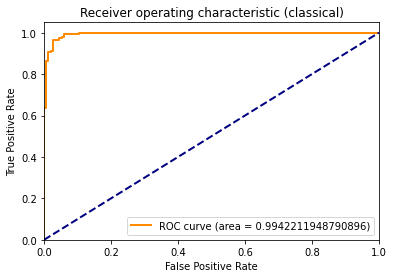

In [112]:
x,y,_ = roc_curve(label_test_sim,c_score_sim,pos_label=8)
plot_roc_binary(x,y,c_auc_sim,"classical")

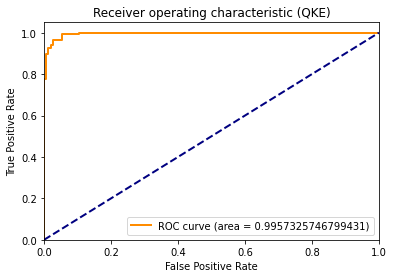

In [114]:
x,y,_ = roc_curve(label_test_sim,qke_score_sim,pos_label=8)
plot_roc_binary(x,y,qke_auc_sim,"QKE")

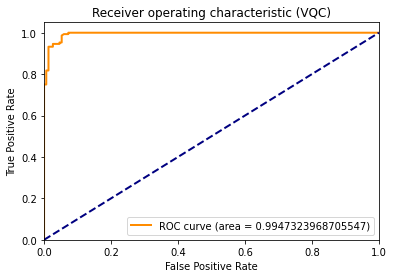

In [115]:
x,y,_ = roc_curve(label_test_sim,vqc_score_sim,pos_label=8)
plot_roc_binary(x,y,vqc_auc_sim,"VQC")

## Ad hoc dataset exploration <a class="anchor" id="AH_de"></a>

In [131]:
from qiskit_machine_learning.datasets import ad_hoc_data

#Build Dataset
train_size = 25
test_size = 150
problem_dimension = 2

X_h, y_h, X_h_test, y_h_test, N = ad_hoc_data(training_size = train_size,
                                           test_size = test_size,
                                           n = problem_dimension,
                                           gap = 0.3,
                                           one_hot = False,
                                           include_sample_total=True)

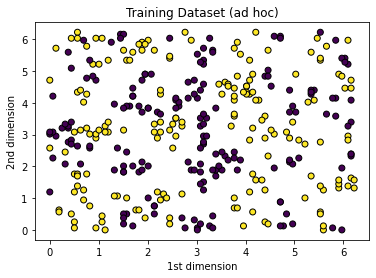

In [132]:
X_full = np.append(X_h,X_h_test,axis=0)
y_full = np.append(y_h,y_h_test,axis=0)

plt.title("Training Dataset (ad hoc)")
plt.xlabel("1st dimension")
plt.ylabel("2nd dimension")
plt.scatter(X_full[:,0],X_full[:,1],c=y_full,edgecolors="k")
plt.show()

## Ad hoc dataset classification <a class="anchor" id="AH_de"></a>

### Classical SVM <a class="anchor" id="MNIST_CL"></a>

In [135]:
#choose kernel type/define a new kernel
kernel_type = "rbf"

#build the classifier
classifier = SVC(kernel=kernel_type,decision_function_shape='ovr',gamma=10.0,probability = True)
classifier.fit(X_h,y_h)

print_support(classifier)

Number of support vectors per class:
Class 0: 24
Class 1: 25


In [154]:
c_score_ah = accuracy_score(y_h_test,classifier.predict(X_h_test))
print(f'Classical SVM test score: {c_score_ah}')

Classical SVM test score: 0.7


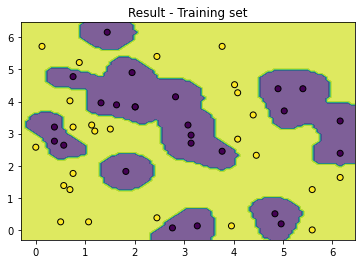

In [136]:
#Plot results
_ = plot_contour(X_h,y_h,classifier,title="Result - Training set",alpha=0.7)

### Quantum Kernel Estimation SVM <a class="anchor" id="AH_QKE"></a>

In [139]:
from qiskit.circuit.library import ZZFeatureMap

#quantum kernel definition
quantum_feature_map_ah = ZZFeatureMap(feature_dimension=problem_dimension, reps=2, entanglement='linear')

quantum_kernel_ah = QuantumKernel(feature_map=quantum_feature_map_ah, quantum_instance=fake_lima)
quantum_kernel_ah_sv = QuantumKernel(feature_map=quantum_feature_map_ah, quantum_instance=sv_simulator)

#definiton of the model
q_svc_ah = SVC(kernel=quantum_kernel_ah.evaluate,decision_function_shape='ovr',probability = True)

#training
q_svc_ah.fit(X_h, y_h)

print_support(q_svc_ah)

Number of support vectors per class:
Class 0: 10
Class 1: 12


In [140]:
qke_preds_ah = q_svc_ah.predict(X_h_test)
qke_score_ah = accuracy_score(y_h_test,qke_preds_ah)
print(f'Quantum kernel classification test score: {qke_score_ah}')

Quantum kernel classification test score: 0.9966666666666667


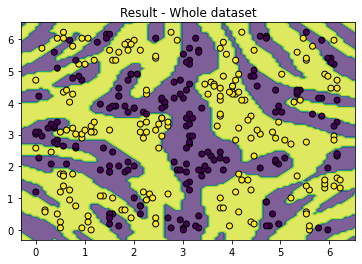

In [143]:
if feature_dim == 2:
    
    #change the kernel used for contour plotting - now we use statevector simulator
    q_svc_ah.set_params(**{"kernel":quantum_kernel_ah_sv.evaluate})
    
    _ = plot_contour(X_full,y_full,q_svc_ah,title=f"Result - Whole dataset",alpha=0.7)

### Variational Quantum Classifier <a class="anchor" id="MNIST_VQC"></a>

In [145]:
#one - hottify
vals = [0,1]
y_h_1h = one_hottify(y_h,vals)
y_h_test_1h = one_hottify(y_h_test,vals)

In [149]:
#Define VQC

#shape parameters
n_input_data = len(X_h[0])
n_qubits = n_input_data
L = 3
L_feature = 2

def VQA_DMF(x:np.ndarray) -> float:
    """Custom Data Mapping Funcion"""
    
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: m * n, x)
    return coeff

ansatz = TwoLocal(n_qubits,["rx","ry"],"cz","linear",reps = L)
loss = CrossEntropyLoss()
optimizer = SPSA(maxiter = 100)

#Callback parameters
C_ah = 0
intermediate_loss_ah = []
weight_parameters_ah = []
skip = 10
    
def callback_ah (w:np.ndarray,loss:float)->None:
    
    global C_ah
    global intermediate_loss_ah
    global weight_parameters_ah

    #at each iteration append the current loss and total number of iterations (both simulated and real hardware)
    intermediate_loss_ah.append((C_ah,loss))
    
    #avoid congestion in the output
    if C_ah%skip == 0: 
        print(f"[{C_ah}] Loss: {loss}")
        
    C_ah+=1
    
    #the final parameters will be saved in this global parmeters
    weight_parameters_ah = w

#initially, we use noisy simulator to reach a warm start for the optimization on the real hardware
vqc_ah = VQC(n_qubits, quantum_feature_map_ah, ansatz, loss, optimizer, quantum_instance = fake_lima, callback=callback_ah)
vqc_ah.fit(X_h,y_h_1h)

[0] Loss: 72.23508349680915
[10] Loss: 76.75095363447606
[20] Loss: 67.18899273697745
[30] Loss: 80.89290769829003
[40] Loss: 77.18565950075073
[50] Loss: 70.0258864581805
[60] Loss: 51.19577614747345
[70] Loss: 35.54496873040098
[80] Loss: 27.94944312811466
[90] Loss: 28.057654244010305
[100] Loss: 23.159624688002367
[110] Loss: 24.635630639624612
[120] Loss: 26.789550138888004
[130] Loss: 21.525560969962303
[140] Loss: 22.259466270356864
[150] Loss: 23.843273380203865
[160] Loss: 22.199116812188155
[170] Loss: 22.645365691426758
[180] Loss: 21.582366675190674
[190] Loss: 23.355578962337812
[200] Loss: 22.1662426353086
[210] Loss: 21.864837192953733
[220] Loss: 23.074077732695873
[230] Loss: 21.4638635730618
[240] Loss: 22.58142240208203
[250] Loss: 20.618189250829065


In [151]:
qpreds_ah = vqc_ah.predict(X_h_test)
qpreds_i_ah = indexify(qpreds_ah,vals)
vqc_score_ah = accuracy_score(y_h_test,qpreds_i_ah)

print(f'Variational classifier test score: {vqc_score_ah}')

Variational classifier test score: 0.9766666666666667


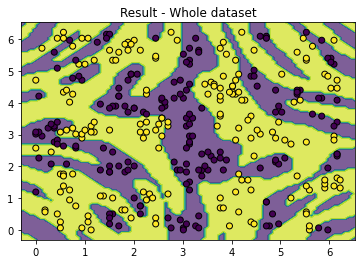

In [152]:
if feature_dim == 2: 
    #change the backend used for contour plotting - now we use statevector simulator
    vqc_ah.neural_network.quantum_instance = sv_simulator
    
    _ = plot_contour(X_full,y_full,vqc_ah,wrapper = lambda x : indexify(x,accepted),title=f"Result - Whole dataset",alpha=0.7)

### Performance metrics <a class="anchor" id="MNIST_me"></a>

Here only accuracy scores are reported. Similar results as before could be obtained with the above code.

In [155]:
scores_ah = (c_score_ah,qke_score_ah,vqc_score_ah)

print_formatted(scores_ah,"ad hoc")

Classical ad hoc:	0.7
QKE ad hoc:      	0.9966666666666667
VQC ad hoc:      	0.9766666666666667
